Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = True

In [2]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>84)
GROUP BY ID
order by potential DESC;
"""



In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,central,winger,offense,Defense,overall_age_ratio,youth_player,age_based_Reactions,age_based_Stamina,age_based_Positioning,age_based_Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,0,1,1.0,13.0,0.170132,False,12.340000,0.040000,26.380000,19.140000
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,0,1,1.0,22.0,0.142400,False,10.272727,10.090909,25.606061,7.333333
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,0,1,1.0,35.0,0.195000,False,4.923077,4.538462,5.538462,4.538462
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,0,1,1.0,35.0,0.224377,True,6.950000,5.200000,15.850000,16.600000
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,0,1,1.0,25.0,0.218837,True,10.571429,10.857143,20.000000,7.071429


In [5]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<83)&(df.Age<26)&(df.Potential>83)]

In [6]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall>82
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.head()

target
False    149
True      89
Name: count, dtype: int64


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,offense,Defense,overall_age_ratio,youth_player,age_based_Reactions,age_based_Stamina,age_based_Positioning,age_based_Vision,set,target
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,1.0,13.0,0.170132,False,12.340000,0.040000,26.380000,19.140000,drop,True
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,1.0,22.0,0.142400,False,10.272727,10.090909,25.606061,7.333333,drop,True
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,1.0,35.0,0.224377,True,6.950000,5.200000,15.850000,16.600000,drop,True
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,1.0,25.0,0.218837,True,10.571429,10.857143,20.000000,7.071429,test,False
208790,Z. Bakkali,2014,17.0,17.0,https://cdn.sofifa.net/players/208/790/14_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,73.0,90.0,PSV,https://cdn.sofifa.net/meta/team/682/30.png,€2.1M,...,1.0,25.0,0.252595,True,2.000000,-4.666667,6.666667,15.333333,train,False


In [7]:
df_processed.best_position.value_counts()

best_position
ST    111
RW     50
LW     50
CF     21
RF      4
LF      2
Name: count, dtype: int64

In [8]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,True,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,True,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,True,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,False,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,False,train,RW


In [9]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [10]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

overall_age_ratio       -0.28
youth_player            -0.28
Defense                 -0.10
Marking                 -0.01
central                 -0.01
SlidingTackle           -0.01
StandingTackle          -0.01
GKReflexes              -0.00
GKPositioning           -0.00
winger                   0.01
GKDiving                 0.05
GKKicking                0.07
GKHandling               0.08
Defensive awareness      0.08
Jumping                  0.08
Agility                  0.10
HeadingAccuracy          0.15
Balance                  0.15
SprintSpeed              0.17
Stamina                  0.18
Strength                 0.18
Interceptions            0.18
age_based_Stamina        0.18
Acceleration             0.18
Unnamed: 0               0.20
Aggression               0.24
LongPassing              0.26
Composure                0.27
max_potential            0.28
FKAccuracy               0.28
Potential                0.28
Crossing                 0.29
Vision                   0.31
age_based_

In [11]:
df[df.Age<20].describe().round(0).compare(df[df.Age>=20].describe().round(0))

potential_age           Age        Overall        Potential         \
               self  other   self  other    self  other      self  other   
count         101.0  137.0  101.0  137.0   101.0  137.0     101.0  137.0   
mean           18.0   22.0   18.0   22.0    70.0   79.0       NaN    NaN   
std             1.0    2.0    1.0    2.0     5.0    4.0       1.0    2.0   
min            16.0   20.0   16.0   20.0    59.0   69.0       NaN    NaN   
25%            17.0   21.0   17.0   21.0    67.0   76.0       NaN    NaN   
50%            18.0   22.0   18.0   22.0    69.0   79.0      85.0   86.0   
75%            19.0   23.0   19.0   23.0    74.0   81.0       NaN    NaN   
max            19.0   25.0   19.0   25.0    81.0   90.0      91.0   95.0   

      Special          ... overall_age_ratio        age_based_Reactions  \
         self   other  ...              self  other                self   
count   101.0   137.0  ...             101.0  137.0               101.0   
mean   1705.0  1921.0  ...               NaN    NaN                -0.0   
std     120.0   110.0  ...               NaN    NaN                 6.0   
min    1424.0  1584.0  ...               NaN    NaN               -15.0   
25%    1626.0  1858.0  ...               NaN    NaN                -4.0   
50%    1697.0  1923.0  ...               NaN    NaN                 0.0   
75%    1794.0  1982.0  ...               NaN    NaN                 3.0   
max    1979.0  2316.0  ...               NaN    NaN                14.0   

             age_based_Stamina        age_based_Positioning         \
       other              self  other                  self  other   
count  137.0             101.0  137.0                 101.0  137.0   
mean     1.0              -1.0    1.0                   6.0   13.0   
std      5.0               6.0    7.0                   9.0    8.0   
min    -11.0             -17.0  -21.0                 -16.0   -8.0   
25%     -2.0              -5.0   -3.0                   0.0    7.0   
50%      1.0              -0.0    1.0                   5.0   13.0   
75%      4.0               4.0    5.0                  11.0   19.0   
max     12.0              16.0   20.0                  36.0   30.0   

      age_based_Vision         
                  self  other  
count            101.0  137.0  
mean               0.0    3.0  
std                NaN    NaN  
min              -22.0  -16.0  
25%               -4.0   -3.0  
50%                0.0    3.0  
75%                5.0    8.0  
max               17.0   19.0  

[8 rows x 106 columns]

In [12]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
bool_age = df.Age == 20
df[df.target&bool_age].describe().round(3).compare(df[~df.target&bool_age].describe().round(0))



potential_age        Age       Overall       Potential         Special  \
               self other self other    self other      self other      self   
count           6.0  20.0  6.0  20.0   6.000  20.0     6.000  20.0     6.000   
mean            NaN   NaN  NaN   NaN  78.000  75.0    87.167  85.0  1910.000   
std             NaN   NaN  NaN   NaN   4.472   3.0     2.137   1.0    93.808   
min             NaN   NaN  NaN   NaN  74.000  69.0       NaN   NaN  1810.000   
25%             NaN   NaN  NaN   NaN  74.250  74.0    86.000  85.0  1838.000   
50%             NaN   NaN  NaN   NaN  77.000  75.0    86.500  85.0  1898.000   
75%             NaN   NaN  NaN   NaN  80.500  76.0    87.750  85.0  1958.000   
max             NaN   NaN  NaN   NaN  85.000  79.0    91.000  88.0  2058.000   

              Unnamed: 0          Crossing       Finishing        \
        other       self    other     self other      self other   
count    20.0      6.000     20.0    6.000  20.0     6.000  20.0   
mean   1831.0  12913.333  11719.0   67.667  66.0    75.833  70.0   
std      97.0   2929.691   1551.0    7.394   9.0     4.792   7.0   
min    1584.0   9136.000   9517.0   59.000  40.0    69.000  57.0   
25%    1777.0  11240.500  10475.0   62.500  65.0    75.000  64.0   
50%    1857.0  12393.000  11672.0   67.000  68.0    75.500  70.0   
75%    1868.0  14748.500  12618.0   71.500  69.0    76.000  74.0   
max    1998.0  17168.000  15881.0   79.000  77.0    84.000  82.0   

      HeadingAccuracy       ShortPassing       Volleys       Dribbling        \
                 self other         self other    self other      self other   
count           6.000  20.0        6.000  20.0   6.000  20.0     6.000  20.0   
mean           65.333  57.0       72.333  70.0  70.833  64.0    80.333  78.0   
std             9.374  12.0        6.346   5.0   6.242   9.0     9.688   5.0   
min            52.000  34.0       66.000  56.0  65.000  44.0    68.000  67.0   
25%            59.750  50.0          NaN   NaN  66.250  59.0    72.500  76.0   
50%            65.500  56.0       71.500  70.0  68.500  64.0    81.500  78.0   
75%            72.750  64.0       77.500  74.0  75.250  72.0    89.000  81.0   
max            76.000  83.0       80.000  79.0  80.000  81.0    90.000  86.0   

        Curve       FKAccuracy       LongPassing       BallControl        \
         self other       self other        self other        self other   
count   6.000  20.0       6.00  20.0       6.000  20.0       6.000  20.0   
mean   73.333  64.0      57.50  58.0      60.167  60.0      79.667  77.0   
std     8.430   7.0      17.74  12.0       9.218   9.0       8.524   4.0   
min    59.000  50.0      33.00  29.0      49.000  40.0      71.000  69.0   
25%    71.250  62.0      43.75  47.0      53.500  53.0      73.500  74.0   
50%    74.000  64.0      63.50  64.0         NaN   NaN         NaN   NaN   
75%    77.500  68.0      69.75  66.0      65.000  66.0      85.750  81.0   
max    84.000  74.0      76.00  75.0         NaN   NaN      92.000  84.0   

      Acceleration       SprintSpeed       Agility       Reactions        \
              self other        self other    self other      self other   
count        6.000  20.0       6.000  20.0   6.000  20.0     6.000  20.0   
mean        84.833  84.0      86.167  83.0     NaN   NaN     2.811  -0.0   
std          7.910   8.0       6.113   6.0   8.672   9.0     4.082   4.0   
min         74.000  65.0      77.000  74.0  74.000  64.0    -3.450 -11.0   
25%         79.250  80.0      82.250  80.0  75.000  78.0     1.782  -3.0   
50%         85.500  86.0      88.000  83.0  80.000  81.0     2.478  -0.0   
75%         91.000  90.0      90.000  88.0  87.250  90.0     4.225   1.0   
max            NaN   NaN         NaN   NaN  95.000  92.0     9.000   7.0   

      Balance       ShotPower       Jumping       Stamina       Strength  \
         self other      self other    self other    self other     self   
count   6.000  20.0     6.000  20.0   6.000  20.0

###  Feature Engineering

In [13]:
PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['age_based_Reactions', 'age_based_Stamina', 'age_based_Positioning','age_based_Vision','Crossing', 'Finishing',  'ShortPassing',  'Dribbling', 'BallControl',
                      'Reactions',  'ShotPower',  'Stamina', 'Strength', 'Aggression',  'Positioning', 'Vision']
# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

#### Transform Defense Attributs

#### Transform Value

In [14]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [15]:
df['target'].value_counts()

target
False    149
True      89
Name: count, dtype: int64

In [16]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [17]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [18]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [19]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=2, scoring='roc_auc')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print("Best AUC:", best_auc)
else:
    PARAMS_RF = {}

[I 2023-10-31 22:15:21,214] A new study created in memory with name: no-name-365aa425-fb58-4393-80c1-aa53e5409a6e
[I 2023-10-31 22:15:21,855] Trial 0 finished with value: 0.6555311355311355 and parameters: {'n_estimators': 264, 'max_depth': 6, 'min_samples_split': 0.2891332221322771, 'min_samples_leaf': 0.16572411222546504, 'max_features': 0.996297432789579}. Best is trial 0 with value: 0.6555311355311355.
[I 2023-10-31 22:15:22,165] Trial 1 finished with value: 0.5642307692307692 and parameters: {'n_estimators': 135, 'max_depth': 6, 'min_samples_split': 0.7543302297526642, 'min_samples_leaf': 0.35425117689560104, 'max_features': 0.7273118601485832}. Best is trial 0 with value: 0.6555311355311355.
[I 2023-10-31 22:15:23,055] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 0.5356771897966094, 'min_samples_leaf': 0.43155660626615666, 'max_features': 0.6077160057906376}. Best is trial 0 with value: 0.6555311355311355.
[I 2023-10-

Best hyperparameters: {'n_estimators': 277, 'max_depth': 3, 'min_samples_split': 0.1590750997289399, 'min_samples_leaf': 0.10466095835962441, 'max_features': 0.5548944996651545}
Best AUC: 0.6953113553113552


In [20]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=2, scoring='roc_auc')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print("Best AUC:", best_auc)
else:
    PARAM_DT = {}

[I 2023-10-31 22:16:06,749] A new study created in memory with name: no-name-aaf3f6d7-6048-4d8c-bc3f-8f6d92a9c706
[I 2023-10-31 22:16:06,796] Trial 0 finished with value: 0.5807142857142856 and parameters: {'max_depth': 6, 'min_samples_split': 0.8468167159068032, 'min_samples_leaf': 0.47967537021439444, 'max_features': 0.525038439843725}. Best is trial 0 with value: 0.5807142857142856.
[I 2023-10-31 22:16:06,844] Trial 1 finished with value: 0.5628571428571428 and parameters: {'max_depth': 3, 'min_samples_split': 0.7829212290970916, 'min_samples_leaf': 0.17316596004991952, 'max_features': 0.8848122817666366}. Best is trial 0 with value: 0.5807142857142856.
[I 2023-10-31 22:16:06,890] Trial 2 finished with value: 0.5427106227106226 and parameters: {'max_depth': 11, 'min_samples_split': 0.9399680218776741, 'min_samples_leaf': 0.41998124126626, 'max_features': 0.7204681520599454}. Best is trial 0 with value: 0.5807142857142856.
[I 2023-10-31 22:16:06,937] Trial 3 finished with value: 0.58

Best hyperparameters: {'max_depth': 5, 'min_samples_split': 0.6432090931590839, 'min_samples_leaf': 0.17009716961132118, 'max_features': 0.1165224760946848}
Best AUC: 0.75503663003663


In [21]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_child_weight': trial.suggest_float('min_child_weight', 5, 20),  # Adjust the range
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        }

        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=2, scoring='roc_auc')
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print("Best AUC:", best_auc)
else:
    PARAM_XGB = {}


[I 2023-10-31 22:16:09,216] A new study created in memory with name: no-name-cb26e624-33bc-4411-bd46-fa1594c321b4
[I 2023-10-31 22:16:09,605] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 258, 'max_depth': 1, 'min_child_weight': 6.400077649255694, 'subsample': 0.5775772990820187, 'colsample_bytree': 0.7725893316923373, 'learning_rate': 0.01614712324096019, 'reg_alpha': 1.818578301808513, 'reg_lambda': 0.7920843058339353}. Best is trial 0 with value: 0.5.
[I 2023-10-31 22:16:09,852] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 161, 'max_depth': 2, 'min_child_weight': 5.796325476028731, 'subsample': 0.7700670232951028, 'colsample_bytree': 0.9168395303741002, 'learning_rate': 0.17543177063914925, 'reg_alpha': 0.5259624423468161, 'reg_lambda': 0.5068735837633498}. Best is trial 0 with value: 0.5.
[I 2023-10-31 22:16:10,118] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 201, 'max_depth': 5, 'min_child_weight': 7.020444429322907, '

Best hyperparameters: {'n_estimators': 281, 'max_depth': 4, 'min_child_weight': 5.017811267449319, 'subsample': 0.791278358069946, 'colsample_bytree': 0.8547247427017929, 'learning_rate': 0.11084256077844194, 'reg_alpha': 1.5469318500760754, 'reg_lambda': 0.4567376203808468}
Best AUC: 0.655128205128205


# FINAL Model RUN

In [22]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights,** PARAM_DT),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights, ** PARAMS_RF),
    'XGBoost Classifier general': xgb.XGBClassifier(),
                                                                                     
    # 'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(**PARAM_XGB)
    # 'LightGBM Classifier': lgb.LGBMClassifier(** {'n_estimators': 100, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.8090291881142198, 'colsample_bytree': 0.6278496311554949, 'learning_rate': 0.17976777947590364, 'reg_alpha': 0.6699371890412207, 'reg_lambda': 1.5295937299896694})
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)

    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Scaler':scaler,
        'attributes':PLAYER_ATTRIBUTES,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
if False:
    try:
        # Save SHAP values to a pickle file
        with open(f"data/sport_analytics/model/{PREDICTION_NAME}_trained_models.pkl", "wb") as file:
            pickle.dump(model_results, file)
    except:
        print("Fehler save Models",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Decision Tree Classifier training----->
Random Forest Classifier training----->
XGBoost Classifier general training----->
XGBoost Classifier training----->
Model: Decision Tree Classifier
Accuracy: 0.37
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.29      0.45        51
        True       0.16      0.88      0.27         8

    accuracy                           0.37        59
   macro avg       0.55      0.58      0.36        59
weighted avg       0.83      0.37      0.42        59

Confusion Matrix:
[[15 36]
 [ 1  7]]
AUC: 0.74
Precision: 0.16

Model: Random Forest Classifier
Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.78      0.83        51
        True       0.21      0.38      0.27         8

    accuracy                           0.73        59
   macro avg       0.55      0.58      0.55        59
weighted avg       0.80      0.73      0.

# evaluate Model

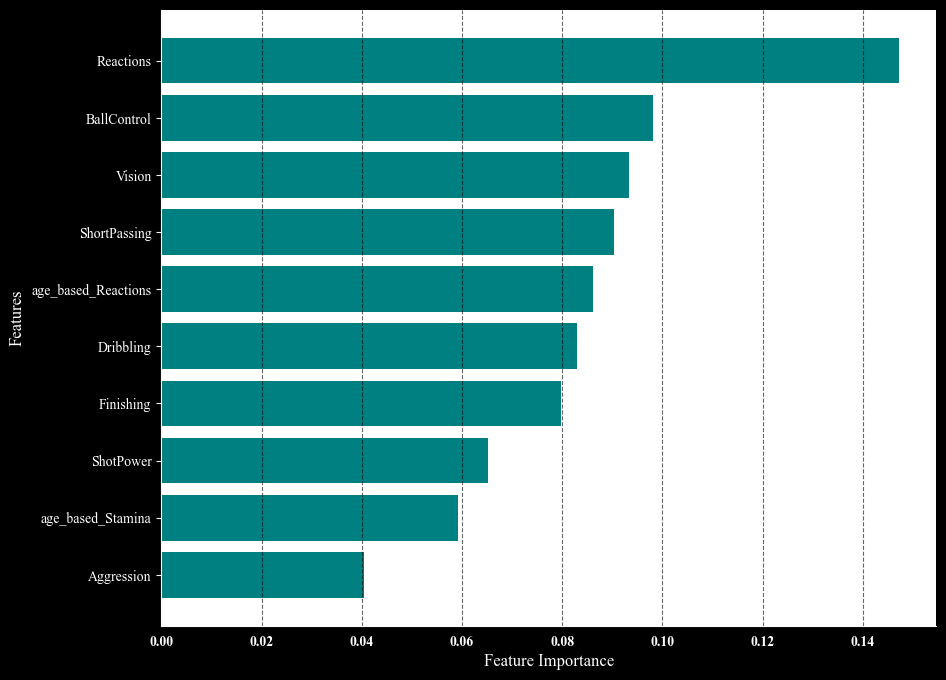

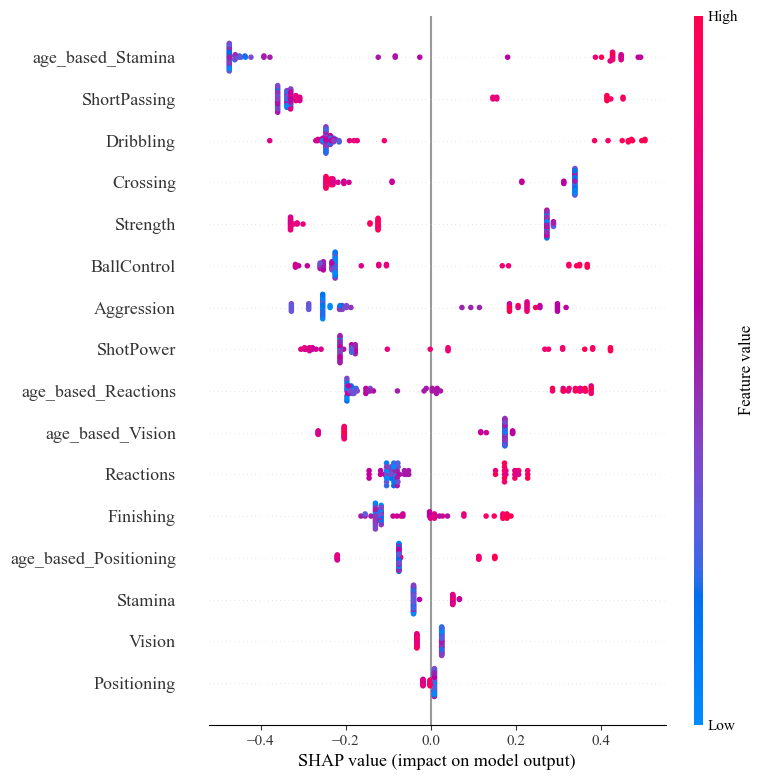

['Reactions',
 'BallControl',
 'Vision',
 'ShortPassing',
 'age_based_Reactions',
 'Dribbling',
 'Finishing',
 'ShotPower',
 'age_based_Stamina',
 'Aggression']

In [23]:
my_model = model_results['XGBoost Classifier']['Model']


from src.sport_analytics.model.eval import individual_shap_valuess,plot_feature_importance

features = plot_feature_importance(my_model, '')
explainer = shap.Explainer(my_model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values, X_test_scaled_df)

features



In [24]:
false_positives = (my_model.predict_proba(X_test_scaled_df)[:,1]>0.5)&(~y_test)
X_test_scaled_df[false_positives]



,,,age_based_Reactions,age_based_Stamina,age_based_Positioning,age_based_Vision,Crossing,Finishing,ShortPassing,Dribbling,BallControl,Reactions,ShotPower,Stamina,Strength,Aggression,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,
243812,Rodrygo,2021,2.220040,1.365698,0.874930,0.566175,0.794988,0.531453,0.369981,0.796549,0.347303,2.220040,-0.470456,1.365698,-1.366694,0.076576,0.874930,0.566175
255475,Antony,2021,-0.075169,0.536856,-0.544493,0.499312,0.135600,-0.482395,0.369981,0.796549,0.968441,-0.075169,-0.750024,0.536856,-0.808615,0.867859,-0.544493,0.499312
247394,D. Kulusevski,2021,1.218107,2.242109,-0.755378,0.624767,0.959835,-0.482395,1.199094,0.234279,0.657872,1.218107,-0.889808,2.242109,0.586583,0.933799,-0.755378,0.624767
216388,A. Saint-Maximin,2019,1.120574,-0.513718,-0.464814,-0.461184,0.300447,-0.482395,0.231795,0.937116,0.502588,1.120574,0.787600,-0.513718,-0.180776,-1.110348,-0.464814,-0.461184
224458,Diogo Jota,2019,1.551666,1.191535,0.378728,0.040635,0.218023,0.024529,0.369981,0.374847,0.813157,1.551666,0.508032,1.191535,0.656343,1.791022,0.378728,0.040635
231943,Richarlison,2021,0.865180,0.766049,0.769487,0.754358,0.877411,1.038377,0.922723,0.796549,0.347303,0.865180,1.067169,0.766049,0.865623,1.922902,0.769487,0.754358
246147,M. Greenwood,2020,1.019141,0.553673,-0.179498,-0.502182,-0.688635,-0.862588,-0.873689,-1.452530,-1.826680,1.019141,-1.029592,0.553673,-0.180776,-0.582827,-0.179498,-0.502182


In [26]:
false_negatives = (my_model.predict_proba(X_test_scaled_df)[:,1]<0.4)&(y_test)
X_test_scaled_df[false_negatives]

,,,age_based_Reactions,age_based_Stamina,age_based_Positioning,age_based_Vision,Crossing,Finishing,ShortPassing,Dribbling,BallControl,Reactions,ShotPower,Stamina,Strength,Aggression,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,
242444,João Félix,2019,1.035722,1.182632,-1.696252,0.904628,0.135600,-1.876436,-0.320947,-0.187423,-0.273835,1.035722,-0.889808,1.182632,-2.273572,-0.121245,-1.696252,0.904628
241721,Rafael Leão,2020,0.275507,-0.327375,0.231729,0.080486,-0.029247,0.277991,-0.459133,-0.187423,-0.429120,0.275507,0.368248,-0.327375,0.865623,0.406277,0.231729,0.080486
232293,V. Osimhen,2020,-0.802222,0.328492,-0.400928,-0.797698,0.135600,0.151260,-0.597318,-1.452530,-1.050258,-0.802222,-0.190888,0.328492,0.865623,1.197560,-0.400928,-0.797698
